170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 61s 519ms/step - accuracy: 0.0897 - loss: 3.3796 - val_accuracy: 0.1027 - val_loss: 2.8680
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 526ms/step - accuracy: 0.1188 - loss: 2.7746 - val_accuracy: 0.1013 - val_loss: 2.5340
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 534ms/step - accuracy: 0.1146 - loss: 2.6237 - val_accuracy: 0.0987 - val_loss: 2.6585
Epoch 4/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 526ms/step - accuracy: 0.1249 - loss: 2.5371 - val_accuracy: 0.0987 - val_loss: 2.3678
Epoch 5/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 81s 515ms/step - accuracy: 0.1314 - loss: 2.4379 - val_accuracy: 0.1127 - val_loss: 2.3528
Epoch 6/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 57s 514ms/step - accuracy: 0.1401 - loss: 2.3746 - val_accuracy: 0.0893 - val_loss: 2.3619
Epoch 7/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 58s 525ms/step - accuracy: 0.1396 - loss: 2.3519 - val_accuracy: 0.0920 - val_loss: 2.3434
Epoch 8/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 83s 532ms/step - accuracy: 0.1567 - loss: 2

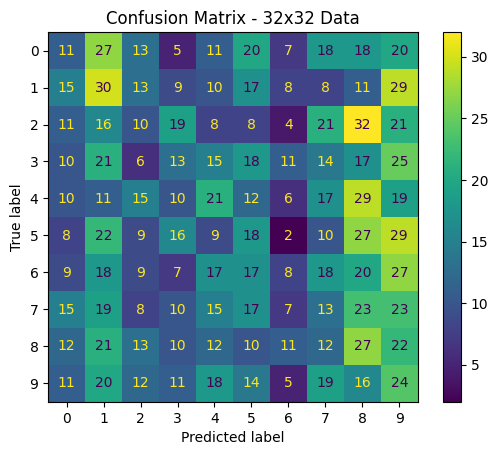

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


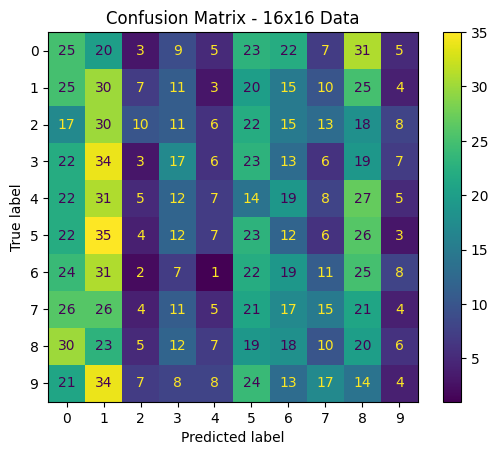

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

(x_data, y_data), (_, _) = tf.keras.datasets.cifar10.load_data()

selected_x, selected_y = [], []
for class_label in range(10):
    class_indices = np.where(y_data.flatten() == class_label)[0][:1000]
    selected_x.append(x_data[class_indices])
    selected_y.append(y_data[class_indices])
x_data = np.vstack(selected_x)
y_data = np.hstack(selected_y)

x_data_resized = tf.image.resize(x_data, (16, 16)).numpy()

x_data = x_data / 255.0
x_data_resized = x_data_resized / 255.0

y_data = y_data.reshape(-1, 1)

x_train_32, x_temp_32, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.3, stratify=y_data.flatten(), random_state=42)
x_val_32, x_test_32, y_val, y_test = train_test_split(x_temp_32, y_temp, test_size=0.5, stratify=y_temp.flatten(), random_state=42)

x_train_16, x_temp_16, _, _ = train_test_split(x_data_resized, y_data, test_size=0.3, stratify=y_data.flatten(), random_state=42)
x_val_16, x_test_16, _, _ = train_test_split(x_temp_16, y_temp, test_size=0.5, stratify=y_temp.flatten(), random_state=42)

def create_model(input_shape):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding='same'),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding='same'),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2), padding='same'),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_32 = create_model((32, 32, 3))
history_32 = model_32.fit(x_train_32, y_train, epochs=25, validation_data=(x_val_32, y_val), batch_size=64)

model_16 = create_model((16, 16, 3))
history_16 = model_16.fit(x_train_16, y_train, epochs=25, validation_data=(x_val_16, y_val), batch_size=64)

def evaluate_performance(model, x_test, y_test, resolution):
    if model.input_shape[1:3] != x_test.shape[1:3]:
        x_test = tf.image.resize(x_test, model.input_shape[1:3]).numpy()
    y_pred = model.predict(x_test).argmax(axis=1)
    y_test = y_test[:len(y_pred)]  # Ensure consistent lengths
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    return accuracy, precision, f1

results = []
results.append(("High-res on High-res", *evaluate_performance(model_32, x_test_32, y_test, "high-resolution")))

low_res_test_32 = tf.image.resize(x_test_32, (16, 16)).numpy()
results.append(("Low-res on High-res", *evaluate_performance(model_32, low_res_test_32, y_test, "low-resolution")))

results.append(("High-res on Low-res", *evaluate_performance(model_16, x_test_32, y_test, "high-resolution with low-resolution model")))

results.append(("Low-res on Low-res", *evaluate_performance(model_16, x_test_16, y_test, "low-resolution with low-resolution model")))

df_results = pd.DataFrame(results, columns=["Scenario", "Accuracy", "Precision", "F1-Score"])
print(df_results)

y_pred_32 = model_32.predict(x_test_32).argmax(axis=1)
conf_matrix_32 = confusion_matrix(y_test[:len(y_pred_32)], y_pred_32)
ConfusionMatrixDisplay(conf_matrix_32, display_labels=range(10)).plot()
plt.title("Confusion Matrix - 32x32 Data")
plt.show()

y_pred_16 = model_16.predict(x_test_16).argmax(axis=1)
conf_matrix_16 = confusion_matrix(y_test[:len(y_pred_16)], y_pred_16)
ConfusionMatrixDisplay(conf_matrix_16, display_labels=range(10)).plot()
plt.title("Confusion Matrix - 16x16 Data")
plt.show()
